In [1]:
import os
import zipfile
import shutil
import gdown

In [2]:
url = 'https://drive.google.com/uc?id=16WRgkzobIr9UY-anwxvLJGKHFdVIkS81'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

!unzip -q dataset.zip
!unzip -q train.zip
!unzip -q test.zip

Downloading...
From: https://drive.google.com/uc?id=16WRgkzobIr9UY-anwxvLJGKHFdVIkS81
To: /content/dataset.zip
100%|██████████| 422M/422M [00:10<00:00, 41.8MB/s]


In [3]:
dataset_home = './'
subdirs = ['train_set/', 'val_set/']

for subdir in subdirs:
    labeldirs = ['camisas/', 'calcas/', 'sapatos/']
    
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        os.makedirs(newdir, exist_ok=True)

In [4]:
from sklearn.model_selection import train_test_split

where_is_data = 'train'
all_data = os.listdir(where_is_data)
train_data, val_data = train_test_split(all_data, test_size=0.2)

In [5]:
for dst_data, dst_set_name in zip([train_data, val_data], ['train_set/', 'val_set/']):
    for f_name in dst_data:
        if f_name.startswith('camisa'):
            src = 'train/' + f_name
            dst = dst_set_name + 'camisas/' + f_name
            os.rename(src, dst)

        elif f_name.startswith('calca'):
            src = 'train/' + f_name
            dst = dst_set_name + 'calcas/' + f_name
            os.rename(src, dst)
        
        elif f_name.startswith('sapato'):
            src = 'train/' + f_name
            dst = dst_set_name + 'sapatos/' + f_name
            os.rename(src, dst)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'train_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'val_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 969 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [7]:
from tensorflow.keras.applications import InceptionV3

model_inception = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classifier_activation="softmax",
)

for layer in model_inception.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [9]:
transferred_model= Sequential([
    model_inception,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

transferred_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = transferred_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
31/31 [==============================] - 21s 245ms/step - loss: 4.9304 - accuracy: 0.8751 - val_loss: 1.2135 - val_accuracy: 0.9630
Epoch 2/5
31/31 [==============================] - 4s 113ms/step - loss: 0.4570 - accuracy: 0.9856 - val_loss: 1.5884 - val_accuracy: 0.9506
Epoch 3/5
31/31 [==============================] - 4s 126ms/step - loss: 0.3233 - accuracy: 0.9783 - val_loss: 1.3960 - val_accuracy: 0.9630
Epoch 4/5
31/31 [==============================] - 4s 127ms/step - loss: 0.1448 - accuracy: 0.9907 - val_loss: 1.2384 - val_accuracy: 0.9753
Epoch 5/5
31/31 [==============================] - 3s 109ms/step - loss: 0.0325 - accuracy: 0.9979 - val_loss: 1.2828 - val_accuracy: 0.9753


In [11]:
loss, accuracy = transferred_model.evaluate(validation_generator)
print("Inception Model Accuracy: ", accuracy)

8/8 [==============================] - 1s 80ms/step - loss: 1.2828 - accuracy: 0.9753
Inception Model Accuracy:  0.9753086566925049


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img_array, img

def display_prediction(img_path, model):
    img_array, img = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)

    plt.imshow(img)
    plt.axis('off')

    predicted_class = np.argmax(prediction)

    if predicted_class == 0:
        accuracy = prediction[0][predicted_class] * 100
        plt.title("Prediction: Calça {:.2f}%".format(accuracy))
    elif predicted_class == 1:
        accuracy = prediction[0][predicted_class] * 100
        plt.title("Prediction: Camisa {:.2f}%".format(accuracy))
    else:
        accuracy = prediction[0][predicted_class] * 100
        plt.title("Prediction: Sapato {:.2f}%".format(accuracy))


    plt.show()

In [13]:
all_files = os.listdir('test')

for i, f_name in enumerate(all_files, start=1):
    new_name = f"{i}.jpg"
    os.rename(os.path.join('test', f_name), os.path.join('test', new_name))

In [14]:
import random

rand_num = random.randint(1, len(all_files))
img_path = 'test/' + str(rand_num) + '.jpg'

1/1 [==============================] - 2s 2s/step


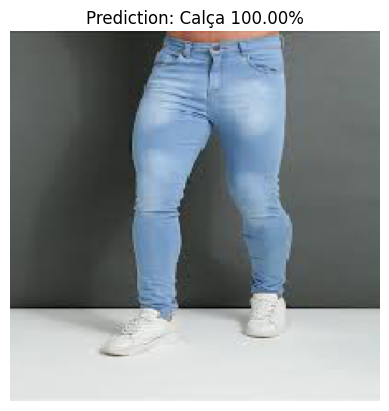

In [15]:
display_prediction(img_path, transferred_model)

In [16]:
transferred_model.save('model-final.h5')